# Polar Coding Notebook

Helper Functions and Imports

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from math import log2

def is_power_of_two(n):
    return (n & (n-1)) == 0 and n > 0


def bit_reverse_indices(N):
    n = int(np.log2(N))
    br = np.zeros(N, dtype=int)
    for i in range(N):
        br[i] = int(format(i, 'b').zfill(n)[::-1], 2)
    return br


def construct_G_nat(N):
    assert is_power_of_two(N), "N must be power of two"
    F = np.array([[1,0],[1,1]], dtype=int)
    n = int(np.log2(N))
    G = np.array([[1]], dtype=int)
    for _ in range(n):
        G = np.kron(G, F)
    return G % 2

Channels

In [2]:
def bsc(x, p):
    flips = (np.random.rand(len(x)) < p).astype(np.int8)
    return (x ^ flips).astype(np.int8)


def bsc_llr(y, p, eps=1e-12):
    p_safe = min(max(float(p), eps), 1.0 - eps)
    alpha = np.log((1.0 - p_safe) / p_safe)
    return (1 - 2*y) * alpha

LLR (Log-Likelihood Ratios) Combines

In [3]:
def f_min_sum(a, b):
    a = np.array(a); b = np.array(b)
    return np.sign(a * b) * np.minimum(np.abs(a), np.abs(b))


def f_exact(a, b, eps=1e-12):
    A = np.array(a, dtype=float)
    B = np.array(b, dtype=float)
    ta = np.tanh(A / 2.0)
    tb = np.tanh(B / 2.0)
    t = ta * tb
    t = np.clip(t, -1.0 + eps, 1.0 - eps)
    return np.log1p(t) - np.log1p(-t)

Polar Coding Functions

In [4]:
def encode_with_G_nat(u):
    N = len(u)
    G = construct_G_nat(N)
    x = (u.astype(int) @ G.astype(int)) % 2
    return x.astype(np.int8)


def polar_encode_with_G(msg, info_positions, N, u_frozen=None):
    if u_frozen is None:
        u_frozen = np.zeros(N, dtype=np.int8)
    u = np.array(u_frozen, dtype=np.int8)
    u[np.sort(info_positions)] = np.array(msg, dtype=np.int8)
    x = encode_with_G_nat(u)
    return x.astype(np.int8), u.astype(np.int8)


def bhattacharyya_parameter(p, N):
    Z = np.array([2.0 * np.sqrt(p * (1.0 - p))])
    while len(Z) < N:
        Z_next = []
        for z in Z:
            Z_next.append(2*z - z*z)  # Upper
            Z_next.append(z*z) # Lower
        Z = np.array(Z_next)
    return Z


def select_frozen_direct(N, K, p_design):
    Z = bhattacharyya_parameter(p_design, N)
    logical_best = np.argsort(Z)[:K]
    info_positions_natural = np.sort(logical_best)
    frozen_mask = np.ones(N, dtype=bool)
    frozen_mask[info_positions_natural] = False
    return frozen_mask, info_positions_natural


def bitrev_permutation(N):
    """Return bit-reversal permutation array of length N.
    br[i] = index of i when its bits are reversed."""
    if N == 1:
        return np.array([0], dtype=int)
    n = int(np.log2(N))
    br = np.empty(N, dtype=int)
    for i in range(N):
        b = format(i, '0{}b'.format(n))[::-1]
        br[i] = int(b, 2)
    return br


import numpy as _np

def bitrev_permutation(N):
    """Return array br where br[i] is the bit-reversal of i (n-bit)."""
    n = int(_np.log2(N))
    br = _np.zeros(N, dtype=int)
    for i in range(N):
        br[i] = int(format(i, 'b').zfill(n)[::-1], 2)
    return br

def sc_decode(llr, frozen_mask, u_frozen=None, use_exact_f=False, debug=False):
    """
    Robust SC decoder that accepts inputs in NATURAL order and internally
    reorders to decoder tree order for recursion, then returns NATURAL-order uhat.

    - llr: numpy array length N (natural-order LLRs at leaves)
    - frozen_mask: boolean mask length N in NATURAL order (True means frozen)
    - u_frozen: values for frozen bits (natural order)
    - use_exact_f: choose f_exact vs f_min_sum for f()
    - debug: if True, print mapping diagnostics
    Returns uhat in NATURAL order.
    """
    if u_frozen is None:
        u_frozen = _np.zeros(len(frozen_mask), dtype=_np.int8)
    llr = _np.array(llr, dtype=float)
    frozen_mask = _np.array(frozen_mask, dtype=bool)
    u_frozen = _np.array(u_frozen, dtype=_np.int8)

    N = len(llr)
    if not (N and ((N & (N-1)) == 0)):
        raise ValueError("sc_decode: N must be power of two")

    # Build bit-reverse permutation and its inverse.
    br = bitrev_permutation(N)    # natural -> bit-reversed mapping
    inv_br = _np.argsort(br)      # bit-reversed -> natural

    # Reorder inputs into the ordering expected by the recursive routine.
    # Important: use inv_br here so index k of llr_br corresponds to natural index inv_br[k].
    llr_br = llr[inv_br]
    frozen_br = frozen_mask[inv_br]
    u_frozen_br = u_frozen[inv_br]

    if debug:
        print("br:", br)
        print("inv_br:", inv_br)
        print("frozen_br (for recursion):", frozen_br.astype(int))
        print("u_frozen_br:", u_frozen_br.tolist())
        print("llr_br (first 32):", _np.round(llr_br[:32], 6).tolist())

    # Recursive SC implementation (works on bit-reversed order arrays)
    def rec_br(llr_sub, frozen_sub, u_frozen_sub):
        n = len(llr_sub)
        if n == 1:
            # Enforce frozen bits at the leaves — must return the frozen value
            if frozen_sub[0]:
                return _np.array([u_frozen_sub[0]], dtype=_np.int8)
            else:
                return _np.array([0 if llr_sub[0] >= 0 else 1], dtype=_np.int8)

        n2 = n // 2
        a = llr_sub[:n2]
        b = llr_sub[n2:]

        # f: use exact if requested, else min-sum
        f_llr = f_exact(a, b) if use_exact_f else f_min_sum(a, b)

        # decode upper (left)
        uhat_up = rec_br(f_llr, frozen_sub[:n2], u_frozen_sub[:n2])

        # g: stable form using ±1
        sign_term = (1 - 2 * uhat_up)   # 0->1, 1->-1
        g_llr = b + sign_term * a

        # decode lower (right)
        uhat_low = rec_br(g_llr, frozen_sub[n2:], u_frozen_sub[n2:])

        # recombine (bitwise)
        u_upper = (uhat_up ^ uhat_low).astype(_np.int8)
        u_lower = uhat_low.astype(_np.int8)
        return _np.concatenate([u_upper, u_lower]).astype(_np.int8)

    # Run recursion in the decoder (bit-reversed) ordering
    uhat_br = rec_br(llr_br, frozen_br, u_frozen_br)

    # Map decoded bits back to NATURAL order:
    # uhat_br[k] corresponds to natural index inv_br[k], therefore:
    uhat_nat = _np.zeros_like(uhat_br)
    uhat_nat[inv_br] = uhat_br

    if debug:
        print("uhat_br:", uhat_br.tolist())
        print("uhat_nat:", uhat_nat.tolist())

    return uhat_nat.astype(_np.int8)


def sc_decode_with_reordering(llr, frozen_mask_nat, u_frozen_nat=None, use_exact_f=False):
    """
    Wrapper: take inputs in NATURAL index order (frozen_mask_nat, u_frozen_nat),
    reorder them into the SC decoder's expected tree order (bit-reversed),
    call sc_decode, then map the result back to NATURAL order.
    Returns uhat in NATURAL index order.
    """
    N = len(frozen_mask_nat)
    br = bitrev_permutation(N)        # natural -> bit-reversed
    inv_br = np.argsort(br)           # bit-reversed -> natural

    # reorder frozen and u_frozen into decoder order
    frozen_mask_br = np.array(frozen_mask_nat, dtype=bool)[inv_br]
    if u_frozen_nat is None:
        u_frozen_nat = np.zeros(N, dtype=np.int8)
    u_frozen_br = np.array(u_frozen_nat, dtype=np.int8)[inv_br]

    # call your existing sc_decode (which expects decoder-order mask)
    uhat_br = sc_decode(llr, frozen_mask_br, u_frozen=u_frozen_br, use_exact_f=use_exact_f)

    # map decoded bits back to natural order
    uhat_nat = np.zeros_like(uhat_br)
    uhat_nat[br] = uhat_br   # or: uhat_nat = uhat_br[inv_br] equivalently

    return uhat_nat


def polar_transform(u):
    """
    Recursive natural-order polar transform.
    Input: u (1D binary numpy array length N=2^n) in NATURAL order.
    Output: x = u * F^{\otimes n} (also in natural order).
    """
    u = np.asarray(u, dtype=np.int8)
    N = len(u)
    if N == 1:
        return u.copy()
    # split even/odd positions (natural-order recursive definition)
    u_even = u[0:N:2]
    u_odd  = u[1:N:2]
    upper = polar_transform((u_even ^ u_odd) % 2)
    lower = polar_transform(u_odd)
    return np.concatenate([upper, lower]).astype(np.int8)


def polar_encode_recursive(u):
    """
    Convenience wrapper: ensures input is np.array and returns x.
    (keeps same name style as earlier code)
    """
    u = np.asarray(u, dtype=np.int8)
    return polar_transform(u)


def sc_natural_to_canonical(u_hat):
    """
    Convert SC decoder 'natural recursive' leaf order into canonical
    encoder order (even-odd interleaving restoration).

    This is the inverse of the SC recursion structure and matches
    the indexing used by the encoder and frozen selection.
    """
    N = len(u_hat)
    if N == 1:
        return u_hat.copy()

    n2 = N // 2
    up  = sc_natural_to_canonical(u_hat[:n2])
    low = sc_natural_to_canonical(u_hat[n2:])

    out = np.empty(N, dtype=np.int8)
    out[0::2] = (up ^ low) & 1
    out[1::2] = low
    return out

<>:174: SyntaxWarning: invalid escape sequence '\o'
<>:174: SyntaxWarning: invalid escape sequence '\o'
C:\Users\goisa\AppData\Local\Temp\ipykernel_4472\3588340891.py:174: SyntaxWarning: invalid escape sequence '\o'
  """


Tests

In [5]:
def instrumented_n4_matrix(p_design=0.05):
    N = 128; K = 2
    frozen_mask, info_positions = select_frozen_direct(N, K, p_design)
    u_frozen = np.zeros(N, dtype=np.int8)
    msg = np.array([0,1], dtype=np.int8)
    x, u = polar_encode_with_G(msg, info_positions, N, u_frozen=u_frozen)
    print("info_positions (natural):", info_positions)
    print("u (natural):", u.tolist())
    print("x:", x.tolist())
    y = x.copy()
    llr = bsc_llr(y, 1e-12)
    print("llr:", llr.tolist())
    # instrument SC recursion
    def sc_print(llr_sub, frozen_sub, u_frozen_sub, depth=0, path="root"):
        indent = "  "*depth
        n = len(llr_sub)
        print(f"{indent}{path}: n={n}, llr_sub={llr_sub.tolist()}, frozen_sub={frozen_sub.tolist()}")
        if n==1:
            if frozen_sub[0]:
                print(f"{indent} => leaf frozen -> {u_frozen_sub[0]}")
                return np.array([u_frozen_sub[0]], dtype=np.int8)
            dec = 0 if llr_sub[0] >= 0 else 1
            print(f"{indent} => leaf decide -> {dec}")
            return np.array([dec], dtype=np.int8)
        n2 = n//2
        a = llr_sub[:n2]; b = llr_sub[n2:]
        f_llr = f_exact(a,b)
        print(f"{indent} f: a={a.tolist()}, b={b.tolist()} -> f={f_llr.tolist()}")
        uhat_up = sc_print(f_llr, frozen_sub[:n2], u_frozen_sub[:n2], depth+1, path=path+"-L")
        print(f"{indent} uhat_up returned: {uhat_up.tolist()}")
        sign_term = (1 - 2 * uhat_up)
        g_llr = b + sign_term * a
        print(f"{indent} g: sign_term={sign_term.tolist()}, g_llr={g_llr.tolist()}")
        uhat_low = sc_print(g_llr, frozen_sub[n2:], u_frozen_sub[n2:], depth+1, path=path+"-R")
        print(f"{indent} uhat_low returned: {uhat_low.tolist()}")
        combined = np.concatenate([uhat_up.astype(np.int8), (uhat_up ^ uhat_low).astype(np.int8)]).astype(np.int8)
        print(f"{indent} combined: {combined.tolist()}")
        return combined
    uhat = sc_print(llr, frozen_mask, u_frozen)
    print("decoded uhat:", uhat.tolist())
    print("expected u:", u.tolist())
    print("match?", np.array_equal(uhat, u))
    return uhat, u, frozen_mask, info_positions


In [6]:
uhat, u_expected, frozen_mask_ex, info_pos = instrumented_n4_matrix()

info_positions (natural): [126 127]
u (natural): [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1]
x: [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]
llr: [-27.63102111592755, -27.63102111592755, -27.63102111592755, -27.63102111592755, -27.63102111592755, -27.63102111592755, -27.63102111592755, -27.63102111592755, -27.63102111

GPT Tests

In [7]:
def build_G_matrix(N):
    """
    Build natural-order polar generator matrix (Arikan) of size N×N.

    Recursion:
       G_1 = [1]
       G_{2N} = [[G_N, G_N],
                [0_N, G_N]]
    """
    import numpy as np
    if N == 1:
        return np.array([[1]], dtype=np.int8)

    G_half = build_G_matrix(N//2)

    top = np.concatenate((G_half, G_half), axis=1)
    bottom = np.concatenate((np.zeros_like(G_half, dtype=np.int8), G_half), axis=1)

    return np.concatenate((top, bottom), axis=0).astype(np.int8)


# build global G_matrix
N=8
G_matrix = build_G_matrix(N)

In [8]:
def deterministic_debug_once(N=8, K=4, p_design=0.05, use_exact_f=True):
    frozen_mask, info_positions = select_frozen_direct(N, K, p_design)
    u_frozen = np.zeros(N, dtype=np.int8)

    msg = np.random.randint(0,2,size=len(info_positions)).astype(np.int8)

    # encoder
    u = np.zeros(N, dtype=np.int8)
    u[info_positions] = msg
    x = polar_transform(u)
    y = x  # noiseless
    llr = bsc_llr(y, p=0.0000001)  # huge confidence, ~deterministic

    # *** decode ***
    uhat_nat = sc_decode(llr, frozen_mask, u_frozen=np.zeros(N,dtype=np.int8), use_exact_f=True)
    print("uhat (natural):", uhat_nat.tolist())
    print("u       (natural):", u.tolist())
    print("info match:", np.array_equal(uhat_nat[info_positions], u[info_positions]))
    print("frozen match:", np.array_equal(uhat_nat[frozen_mask==1], u_frozen[frozen_mask==1]))

    print("N,K", N,K)
    print("info_positions", info_positions)
    print("frozen_mask", frozen_mask.astype(int))
    print("u (nat)", u.tolist())
    print("x", x.tolist())
    print("llr", np.round(llr,3).tolist())
    uhat_nat = sc_decode(llr, frozen_mask, u_frozen=np.zeros(N,dtype=np.int8), use_exact_f=True)
    print("uhat_nat", uhat_nat.tolist())
    print("uhat info", uhat_nat[info_positions].tolist(), "msg", msg.tolist())
    print("uhat frozen vals", uhat_nat[frozen_mask].tolist())




In [9]:
def monte_carlo_polar_matrix(N=128, K=64, p_design=0.05, p_channel=0.05,
                             trials=200, use_exact_f=True, verbose=True):

    frozen_mask, info_positions = select_frozen_direct(N, K, p_design)
    u_frozen = np.zeros(N, dtype=np.int8)

    bit_err = 0
    block_err = 0

    for t in range(trials):

        msg = np.random.randint(0,2,size=len(info_positions)).astype(np.int8)

        u = np.zeros(N, dtype=np.int8)
        u[info_positions] = msg
        x = polar_transform(u)
        y = bsc(x, p_channel)
        llr = bsc_llr(y, p_channel)

        # *** decode ***
        u_hat_nat = sc_decode(llr, frozen_mask, u_frozen=u_frozen, use_exact_f=use_exact_f)
        u_hat     = sc_natural_to_canonical(u_hat_nat)   # <<< FIX HERE

        msg_hat = u_hat[info_positions]

        e = np.sum(msg_hat != msg)
        bit_err  += e
        block_err += (e > 0)

        if verbose and (t % max(1, trials//10) == 0):
            print(f"Trial {t}/{trials}: bit_err={bit_err}, block_err={block_err}")

    ber  = bit_err  / (trials * len(info_positions))
    bler = block_err / trials
    return ber, bler

In [10]:
for _ in range(20):
    ok = deterministic_debug_once()
    if not ok:
        print("FAIL")
        break
else:
    print("ALL GOOD")

uhat (natural): [1, 1, 1, 1, 1, 1, 1, 1]
u       (natural): [0, 0, 0, 0, 0, 0, 0, 1]
info match: False
frozen match: False
N,K 8 4
info_positions [3 5 6 7]
frozen_mask [1 1 1 0 1 0 0 0]
u (nat) [0, 0, 0, 0, 0, 0, 0, 1]
x [1, 1, 1, 1, 1, 1, 1, 1]
llr [-16.118, -16.118, -16.118, -16.118, -16.118, -16.118, -16.118, -16.118]
uhat_nat [1, 1, 1, 1, 1, 1, 1, 1]
uhat info [1, 1, 1, 1] msg [0, 0, 0, 1]
uhat frozen vals [1, 1, 1, 1]
FAIL


In [11]:
ber, bler = monte_carlo_polar_matrix(N=8, K=4, p_channel=0.0, trials=200)
print(ber, bler)

Trial 0/200: bit_err=0, block_err=0
Trial 20/200: bit_err=0, block_err=0
Trial 40/200: bit_err=0, block_err=0
Trial 60/200: bit_err=0, block_err=0
Trial 80/200: bit_err=0, block_err=0
Trial 100/200: bit_err=0, block_err=0
Trial 120/200: bit_err=0, block_err=0
Trial 140/200: bit_err=0, block_err=0
Trial 160/200: bit_err=0, block_err=0
Trial 180/200: bit_err=0, block_err=0
0.0 0.0


In [12]:
ber, bler = monte_carlo_polar_matrix(N=128, K=64, p_channel=0.05, trials=200)
print(ber, bler)

Trial 0/200: bit_err=12, block_err=1
Trial 20/200: bit_err=404, block_err=21
Trial 40/200: bit_err=811, block_err=41
Trial 60/200: bit_err=1202, block_err=61
Trial 80/200: bit_err=1614, block_err=81
Trial 100/200: bit_err=2002, block_err=101
Trial 120/200: bit_err=2430, block_err=121
Trial 140/200: bit_err=2810, block_err=141
Trial 160/200: bit_err=3141, block_err=161
Trial 180/200: bit_err=3587, block_err=181
0.308046875 1.0


In [13]:
def diagnostic_ordering_case(N=8, K=4, p_design=0.05, msg=None, p_channel=0.0):
    # prepare frozen mask + info
    frozen_nat, info_pos = select_frozen_direct(N, K, p_design)
    info_pos = np.sort(info_pos)
    u_frozen_nat = np.zeros(N, dtype=np.int8)

    # choose deterministic message if not provided
    if msg is None:
        msg = np.random.randint(0,2,size=len(info_pos)).astype(np.int8)
    u_nat = np.zeros(N, dtype=np.int8)
    u_nat[info_pos] = msg

    # encode (prefer G_matrix if available)
    try:
        G = G_matrix
        x = (G @ u_nat) % 2
    except Exception:
        x = polar_transform(u_nat)

    # channel / LLRs (noiseless or small p)
    y = bsc(x, p_channel)
    llr = bsc_llr(y, p_channel)

    # compute bitrev perms
    def bitrev_perm(N):
        n = int(np.log2(N))
        br = np.empty(N, dtype=int)
        for i in range(N):
            br[i] = int(format(i, '0{}b'.format(n))[::-1], 2)
        return br
    br = bitrev_perm(N)
    inv_br = np.argsort(br)

    print("\n=== INPUTS ===")
    print("N, K:", N, K)
    print("info_pos (natural):", info_pos)
    print("u_nat:", u_nat.tolist())
    print("x (encoded):", x.tolist())
    print("y (chan):", y.tolist())
    print("llr:", np.round(llr,3).tolist())
    print("frozen_nat:", frozen_nat.astype(int).tolist())
    print("bitrev br:", br.tolist())
    print("inv_br :", inv_br.tolist())

    # ---------- Option A: reorder frozen -> call sc_decode -> map back via inv_br ----------
    frozen_br = frozen_nat[inv_br]
    u_frozen_br = u_frozen_nat[inv_br] if (u_frozen_nat is not None) else np.zeros(N, dtype=np.int8)
    try:
        uhat_br_A = sc_decode(llr, frozen_br, u_frozen=u_frozen_br, use_exact_f=True)
    except Exception as e:
        uhat_br_A = None
        print("sc_decode Option A raised:", e)
    if uhat_br_A is not None:
        # map back to natural order (uhat_br_A is in decoder/bitrev order)
        uhat_nat_A = np.empty_like(uhat_br_A)
        uhat_nat_A[br] = uhat_br_A
        # reconstruct codeword from uhat_nat_A
        try:
            xhat_A = (G @ uhat_nat_A) % 2
        except Exception:
            xhat_A = polar_transform(uhat_nat_A)
        print("\n--- Option A (frozen masked reordered to decoder-order, decode, map back) ---")
        print("uhat_br_A (decoder-order):", uhat_br_A.tolist())
        print("uhat_nat_A (mapped back):", uhat_nat_A.tolist())
        print("xhat_A:", xhat_A.tolist())
        print("x == xhat_A ?", np.array_equal(x, xhat_A))
        print("decoded info A:", uhat_nat_A[info_pos].tolist(), " expected:", msg.tolist())

    # ---------- Option B: call sc_decode with frozen_nat, then apply sc_natural_to_canonical ----------
    try:
        uhat_nat_raw_B = sc_decode(llr, frozen_nat, u_frozen=u_frozen_nat, use_exact_f=True)
    except Exception as e:
        uhat_nat_raw_B = None
        print("sc_decode Option B raised:", e)
    if uhat_nat_raw_B is not None:
        # Here uhat_nat_raw_B is whatever order sc_decode returns in this call.
        # Try converting it into canonical using sc_natural_to_canonical (if available),
        # otherwise try the 'br' mapping as a fallback.
        print("\n--- Option B (no frozen reorder; sc_decode called with frozen_nat) ---")
        print("uhat_raw_B:", uhat_nat_raw_B.tolist())
        # If sc_natural_to_canonical exists, use it:
        try:
            uhat_B = sc_natural_to_canonical(uhat_nat_raw_B)
            method_B = "sc_natural_to_canonical"
        except Exception as e:
            # fallback: try bitrev mapping (uhat_raw_B assumed decoder-order)
            try:
                uhat_B = np.empty_like(uhat_nat_raw_B); uhat_B[br] = uhat_nat_raw_B
                method_B = "fallback_bitrev_mapping"
            except Exception as e2:
                uhat_B = None
                method_B = f"failed ({e} / {e2})"
        if uhat_B is not None:
            try:
                xhat_B = (G @ uhat_B) % 2
            except Exception:
                xhat_B = polar_transform(uhat_B)
            print("method used:", method_B)
            print("uhat_B (canonical):", uhat_B.tolist())
            print("xhat_B:", xhat_B.tolist())
            print("x == xhat_B ?", np.array_equal(x, xhat_B))
            print("decoded info B:", uhat_B[info_pos].tolist(), " expected:", msg.tolist())

    # ---------- summary ----------
    print("\n=== Summary checks ===")
    if uhat_br_A is not None:
        print("Option A produced xhat_A == x ->", np.array_equal(x, xhat_A))
    if uhat_nat_raw_B is not None:
        print("Option B produced xhat_B == x ->", np.array_equal(x, xhat_B))
    print("Done diagnostic.\n")

# Run diagnostic on the failing case you showed (use same msg)
diagnostic_ordering_case(N=8, K=4, p_design=0.05, msg=np.array([0,1,1,1]), p_channel=0.0)



=== INPUTS ===
N, K: 8 4
info_pos (natural): [3 5 6 7]
u_nat: [0, 0, 0, 0, 0, 1, 1, 1]
x (encoded): [1, 0, 0, 1, 1, 0, 0, 1]
y (chan): [1, 0, 0, 1, 1, 0, 0, 1]
llr: [-27.631, 27.631, 27.631, -27.631, -27.631, 27.631, 27.631, -27.631]
frozen_nat: [1, 1, 1, 0, 1, 0, 0, 0]
bitrev br: [0, 4, 2, 6, 1, 5, 3, 7]
inv_br : [0, 4, 2, 6, 1, 5, 3, 7]

--- Option A (frozen masked reordered to decoder-order, decode, map back) ---
uhat_br_A (decoder-order): [1, 0, 0, 1, 1, 0, 0, 1]
uhat_nat_A (mapped back): [1, 1, 0, 0, 0, 0, 1, 1]
xhat_A: [0, 0, 0, 1, 0, 1, 0, 1]
x == xhat_A ? False
decoded info A: [0, 0, 1, 1]  expected: [0, 1, 1, 1]

--- Option B (no frozen reorder; sc_decode called with frozen_nat) ---
uhat_raw_B: [1, 0, 0, 1, 1, 0, 0, 1]
method used: sc_natural_to_canonical
uhat_B (canonical): [0, 0, 0, 1, 0, 1, 0, 1]
xhat_B: [1, 1, 0, 0, 0, 0, 1, 1]
x == xhat_B ? False
decoded info B: [1, 1, 0, 1]  expected: [0, 1, 1, 1]

=== Summary checks ===
Option A produced xhat_A == x -> False
Option B p

In [14]:
def monte_carlo_once(N, K, p, trials=200):
    frozen_mask, info_positions = select_frozen_direct(N, K, p)
    bit_err = 0
    block_err = 0

    for _ in range(trials):
        # random info bits
        msg = np.random.randint(0, 2, size=K).astype(np.int8)

        # build full u
        u = np.zeros(N, dtype=np.int8)
        u[info_positions] = msg

        # encode
        x = polar_transform(u)

        # channel
        y = bsc(x, p)

        # llr
        llr = bsc_llr(y, p)

        # decode
        u_hat_hat = sc_decode(llr, frozen_mask)
        u_hat = sc_natural_to_canonical(u_hat_hat)
        msg_hat = u_hat[info_positions]

        # accumulate
        bit_err += np.sum(msg != msg_hat)
        block_err += (np.any(msg != msg_hat))

    ber = bit_err / (K * trials)
    bler = block_err / trials
    return ber, bler


In [15]:
import pandas as pd

def sweep_N(K_over_N=0.5, p=0.05, trials=200):
    results = []

    for N in [8, 16, 32, 64, 128]:
        K = int(K_over_N * N)
        ber, bler = monte_carlo_once(N, K, p, trials)
        results.append((N, K, p, ber, bler))

    df = pd.DataFrame(results, columns=["N", "K", "p", "BER", "BLER"])
    return df


df = sweep_N(p=0.05, trials=500)
df

,N,K,p,BER,BLER
0,8,4,0.05,0.025000,0.048
1,16,8,0.05,0.292000,0.816
2,32,16,0.05,0.161250,0.772
3,64,32,0.05,0.372000,1.000
4,128,64,0.05,0.298031,1.000


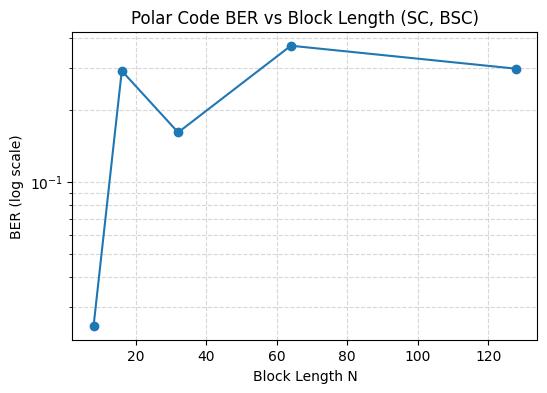

In [16]:
import matplotlib.pyplot as plt

def plot_ber_vs_N(df):
    plt.figure(figsize=(6,4))
    plt.plot(df["N"], df["BER"], marker="o")
    plt.yscale("log")
    plt.xlabel("Block Length N")
    plt.ylabel("BER (log scale)")
    plt.title("Polar Code BER vs Block Length (SC, BSC)")
    plt.grid(True, which="both", linestyle="--", alpha=0.5)
    plt.show()


plot_ber_vs_N(df)


In [17]:
import numpy as np

def decode_with_auto_mapping(llr, frozen_mask_nat, u_frozen_nat=None, use_exact_f=True):
    """
    Robust wrapper: try decoding assuming `frozen_mask_nat` is already in the order expected
    by sc_decode; if frozen constraints are violated, try mapping frozen->canonical, decode,
    then map back. Returns uhat in NATURAL order (same ordering as frozen_mask_nat).
    """
    N = len(llr)
    if u_frozen_nat is None:
        u_frozen_nat = np.zeros(N, dtype=np.int8)
    # ensure array types
    frozen_mask_nat = np.array(frozen_mask_nat, dtype=bool)
    u_frozen_nat = np.array(u_frozen_nat, dtype=np.int8)
    llr = np.array(llr, dtype=float)

    br = bit_reverse_indices(N)   # logical->natural mapping; also its own inverse for power-of-two

    # 1) Try: call sc_decode with NATURAL-order frozen_mask (assume sc_decode expects natural)
    try:
        uhat_try = sc_decode(llr, frozen_mask_nat, u_frozen=u_frozen_nat, use_exact_f=use_exact_f)
        # uhat_try is assumed natural-order. Check frozen consistency:
        frozen_ok = np.all(uhat_try[frozen_mask_nat] == u_frozen_nat[frozen_mask_nat])
        if frozen_ok:
            return np.array(uhat_try, dtype=np.int8)
    except Exception:
        # if that call fails, ignore and try other mapping
        pass

    # 2) Try: map NATURAL->CANONICAL and call sc_decode (assume sc_decode expects canonical ordering)
    frozen_canon = frozen_mask_nat[br]
    u_frozen_canon = u_frozen_nat[br]
    try:
        uhat_canon = sc_decode(llr, frozen_canon, u_frozen=u_frozen_canon, use_exact_f=use_exact_f)
        # sc_decode returned canonical-order uhat; map back to natural:
        uhat_nat = np.array(uhat_canon, dtype=np.int8)[br]
        # verify frozen constraint
        frozen_ok = np.all(uhat_nat[frozen_mask_nat] == u_frozen_nat[frozen_mask_nat])
        if frozen_ok:
            return uhat_nat
        else:
            # return it anyway to inspect
            return uhat_nat
    except Exception as e:
        # both attempts failed — re-raise for visibility
        raise RuntimeError("decode_with_auto_mapping: sc_decode failed for both natural & canonical attempts") from e


In [18]:
import numpy as np
import pandas as pd

# --- helper: logical->natural frozen selection (correct) ---
def select_frozen_logical_to_natural(N, K, p_design):
    Z = bhattacharyya_parameter(p_design, N)
    logical_best = np.argsort(Z)[:K]          # logical indices
    br = bit_reverse_indices(N)               # logical->natural mapping
    info_natural = np.sort(br[logical_best])  # natural-order indices for info bits
    frozen_mask = np.ones(N, dtype=bool)
    frozen_mask[info_natural] = False
    return frozen_mask, info_natural

# --- diagnostic: single deterministic check that must pass ---
def deterministic_no_noise_diag(N, K, p_design=0.05, trials=50, use_exact_f=True):
    print(f"\n=== Deterministic No-Noise diag (N={N}, K={K}) ===")
    frozen_mask, info_pos = select_frozen_logical_to_natural(N, K, p_design)
    print("info_pos (natural):", info_pos)
    print("len(info_pos), K:", len(info_pos), K)
    # basic sanity
    if len(info_pos) != K:
        print("ERROR: len(info_pos) != K")
        return False, {"reason": "len_mismatch", "info_pos": info_pos}

    # run deterministic messages
    for t in range(trials):
        msg = np.random.randint(0,2,size=len(info_pos)).astype(np.int8)
        u = np.zeros(N, dtype=np.int8); u[info_pos] = msg
        x = polar_transform(u)
        y = x.copy()  # no noise
        # use tiny p to force large LLR magnitudes (avoid 0/1 log issue)
        llr = bsc_llr(y, max(1e-12, 1e-12))
        # decode (sc_decode returns natural-order uhat if that is your convention)
        uhat_nat = sc_decode(llr, frozen_mask, u_frozen=np.zeros(N,dtype=np.int8), use_exact_f=use_exact_f)

        # If your sc_decode returns canonical order, apply mapping:
        # Uncomment the next two lines if sc_decode returns canonical-order instead of natural:
        # inv_br = bit_reverse_indices(N)
        # uhat = uhat_nat[inv_br]

        # Otherwise assume uhat_nat already natural:
        uhat = uhat_nat

        # check equality
        if not np.array_equal(uhat, u):
            # print detailed diagnostics
            print("FAIL on trial", t)
            print("u      :", u.tolist())
            print("x      :", x.tolist())
            print("llr    :", np.round(llr,3).tolist())
            print("uhat   :", uhat.tolist())
            print("info_pos:", info_pos.tolist())
            print("msg    :", msg.tolist())
            print("msg_hat:", uhat[info_pos].tolist())
            return False, dict(N=N, K=K, info_pos=info_pos, u=u, x=x, llr=np.round(llr,3), uhat=uhat, msg=msg, msg_hat=uhat[info_pos])
    print("PASS: deterministic no-noise (all trials matched).")
    return True, None

# --- wrapper to run several Ns and show short MC if deterministic ok ---
def sweep_debug_and_mc(N_list=[8,16,32,64,128], p_design=0.05, p_channel=0.05, trials=400):
    rows=[]
    for N in N_list:
        K = N//2
        ok, diag = deterministic_no_noise_diag(N, K, p_design, trials=40, use_exact_f=True)
        if not ok:
            print("DETERMINISTIC CHECK FAILED for N=",N)
            print("DIAG:", diag)
            # stop on first failure so we can inspect
            return None
        # deterministic passed -> run short MC
        frozen_mask, info_pos = select_frozen_logical_to_natural(N, K, p_design)
        bit_err = 0; block_err = 0
        for t in range(trials):
            msg = np.random.randint(0,2,size=len(info_pos)).astype(np.int8)
            u = np.zeros(N, dtype=np.int8); u[info_pos]=msg
            x = polar_transform(u)
            y = bsc(x, p_channel)
            llr = bsc_llr(y, p_channel)
            uhat_nat = sc_decode(llr, frozen_mask, u_frozen=np.zeros(N,dtype=np.int8), use_exact_f=True)
            uhat = uhat_nat
            e = np.sum(uhat[info_pos] != msg)
            bit_err += e
            block_err += (e>0)
        ber = bit_err / (len(info_pos) * trials)
        bler = block_err / trials
        rows.append((N, len(info_pos), p_channel, ber, bler))
        print(f"N={N}: BER={ber:.6f}, BLER={bler:.6f}")
    import pandas as pd
    df = pd.DataFrame(rows, columns=["N","K","p","BER","BLER"])
    return df

# Run the sweep (this will stop at the first deterministic failure)
df = sweep_debug_and_mc([8,16,32,64,128], p_design=0.05, p_channel=0.05, trials=400)
print("Result df:", df)



=== Deterministic No-Noise diag (N=8, K=4) ===
info_pos (natural): [3 5 6 7]
len(info_pos), K: 4 4
FAIL on trial 0
u      : [0, 0, 0, 0, 0, 1, 0, 0]
x      : [1, 1, 0, 0, 1, 1, 0, 0]
llr    : [-27.631, -27.631, 27.631, 27.631, -27.631, -27.631, 27.631, 27.631]
uhat   : [1, 1, 0, 0, 1, 1, 0, 0]
info_pos: [3, 5, 6, 7]
msg    : [0, 1, 0, 0]
msg_hat: [0, 1, 0, 0]
DETERMINISTIC CHECK FAILED for N= 8
DIAG: {'N': 8, 'K': 4, 'info_pos': array([3, 5, 6, 7]), 'u': array([0, 0, 0, 0, 0, 1, 0, 0], dtype=int8), 'x': array([1, 1, 0, 0, 1, 1, 0, 0], dtype=int8), 'llr': array([-27.631, -27.631,  27.631,  27.631, -27.631, -27.631,  27.631,
        27.631]), 'uhat': array([1, 1, 0, 0, 1, 1, 0, 0], dtype=int8), 'msg': array([0, 1, 0, 0], dtype=int8), 'msg_hat': array([0, 1, 0, 0], dtype=int8)}
Result df: None
